In [111]:
from pandas import read_csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tools.plotting import autocorrelation_plot
import statsmodels.api as sm
import math
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller

import itertools
import warnings

In [2]:
#http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/
#https://www.kaggle.com/poiupoiu/how-to-use-sarimax
#https://www.kaggle.com/berhag/co2-emission-forecast-with-python-seasonal-arima
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3

## Reading and preprocessing the data


### NASA GISTEMP Global Means

In [112]:
glb = read_csv('weather_data/GLB.Ts.csv', skiprows=1)
glb.head()

,Year,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,J-D,D-N,DJF,MAM,JJA,SON
0,1880,-0.76,-0.35,-0.42,-0.60,-0.30,-0.42,-0.41,0.13,-0.44,-0.60,-0.45,-0.47,-0.43,***,***,-0.44,-0.24,-0.50
1,1881,-0.74,-0.56,-0.31,-0.21,0.02,-1.05,-0.47,-0.19,-0.29,-0.42,-0.50,-0.09,-0.40,-.43,-.59,-0.16,-0.57,-0.40
2,1882,0.18,-0.05,-0.03,-0.54,-0.33,-0.97,-0.66,-0.06,-0.02,-0.25,-0.34,-0.62,-0.31,-.26,.01,-0.30,-0.56,-0.20
3,1883,-0.62,-0.89,-0.40,-0.26,-0.30,0.50,0.04,-0.10,-0.40,-0.51,-0.63,-0.33,-0.32,-.35,-.71,-0.32,0.15,-0.51
4,1884,-0.56,-0.30,-0.36,-0.90,-1.16,-0.79,-0.81,0.19,-0.33,-0.73,-0.78,-0.97,-0.63,-.57,-.40,-0.81,-0.47,-0.61


In [113]:
#https://data.giss.nasa.gov/gistemp/
def preprocess_temp_anomaly(anomaly):
    
    col_names =  ['DateTime', 'anomaly']
    glb_formatted = pd.DataFrame(columns = col_names)
    
    at = 0
    for index, row in glb.iterrows():
        i = 0
        months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
        for r in row[1:13]:
            date = pd.to_datetime(str(row['Year']) + '-' + months[i])
            value = r
            glb_formatted.loc[at] = [date, value]
            at = at + 1
            i = i + 1
        i= 1
    
    glb_formatted = glb_formatted.set_index(['DateTime'])
    
    return glb_formatted


glb_formatted = preprocess_temp_anomaly(glb)
glb_formatted.head()

,anomaly
DateTime,
1880-01-01,-0.76
1880-02-01,-0.35
1880-03-01,-0.42
1880-04-01,-0.60
1880-05-01,-0.30


### Monthly mean carbon dioxide at Mauna Loa Observatory, Hawaii

In [114]:
columns= ['Year', 'Month', 'Excel', 'Date', 'CO2', 'sesonalCO2', 'FIT','sesonalFIT', 'CO2filled', 'seasonalCO2filled']

maunaloa = read_csv('weather_data/maunaloa.csv', skiprows=57, header=None, names=columns)

maunaloa['DateTime']  = pd.to_datetime(maunaloa.Year.map(str) + '-' + maunaloa.Month.map(str))
maunaloa = maunaloa.set_index(['DateTime'])

maunaloa.head()

,Year,Month,Excel,Date,CO2,sesonalCO2,FIT,sesonalFIT,CO2filled,seasonalCO2filled
DateTime,,,,,,,,,,
1958-01-01,1958,1,21200,1958.0411,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1958-02-01,1958,2,21231,1958.1260,-99.99,-99.99,-99.99,-99.99,-99.99,-99.99
1958-03-01,1958,3,21259,1958.2027,315.70,314.43,316.19,314.90,315.70,314.43
1958-04-01,1958,4,21290,1958.2877,317.45,315.15,317.30,314.98,317.45,315.15
1958-05-01,1958,5,21320,1958.3699,317.51,314.72,317.85,315.06,317.51,314.72


In [115]:
maunaloaFilled = maunaloa[['CO2filled', 'seasonalCO2filled']].copy()
maunaloaFilled.replace(to_replace=[-99.99], value=np.nan, inplace=True)

### The Oceanic Niño Index (ONI) 

In [116]:
#https://data.humdata.org/dataset/monthly-oceanic-nino-index-oni
#https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/detrend.nino34.ascii.txt

In [117]:
enso = read_csv('weather_data/ONIindex.csv',delim_whitespace=True)

In [118]:
enso['DateTime'] = pd.to_datetime(enso.YR.map(str) + '-' + enso.MON.map(str))
enso = enso.set_index(['DateTime']) 

In [119]:
enso.head()

,YR,MON,TOTAL,ClimAdjust,ANOM
DateTime,,,,,
1950-01-01,1950,1,24.56,26.18,-1.62
1950-02-01,1950,2,25.07,26.39,-1.32
1950-03-01,1950,3,25.88,26.95,-1.07
1950-04-01,1950,4,26.29,27.39,-1.11
1950-05-01,1950,5,26.19,27.56,-1.37


### Sunspot Number

In [120]:
#http://www.sidc.be/silso/monthlyssnplot
#http://www.sidc.be/silso/newdataset
columns= ['Year', 'Month', 'decimalYear', 'SNvalue' , 'SNerror', 'NBobservations', 'unspesified']
sunspots = read_csv('weather_data/SN_m_tot_V2.0.csv', sep=';', header=None, names=columns)

In [121]:
sunspots['DateTime'] = pd.to_datetime(sunspots.Year.map(str) + '-' + sunspots.Month.map(str))

In [122]:
sunspots = sunspots.set_index(['DateTime'])  

In [123]:
sunspots.head()

,Year,Month,decimalYear,SNvalue,SNerror,NBobservations,unspesified
DateTime,,,,,,,
1749-01-01,1749,1,1749.042,96.7,-1.0,-1,1
1749-02-01,1749,2,1749.123,104.3,-1.0,-1,1
1749-03-01,1749,3,1749.204,116.7,-1.0,-1,1
1749-04-01,1749,4,1749.288,92.8,-1.0,-1,1
1749-05-01,1749,5,1749.371,141.7,-1.0,-1,1


### Range there is data of all the variables

In [124]:
#Choosing a range there is data of
anomalyrange = glb_formatted['1960-01-01' : '2018-12-01']
co2range = maunaloaFilled[['CO2filled']]['1960-01-01' : '2018-12-01']  #.CO2filled['1960-01-01' : '2018-12-01']
ensorange = enso[['ANOM']]['1960-01-01' : '2018-12-01']
spotsrange = sunspots[['SNvalue']]['1960-01-01' : '2018-12-01']

In [125]:
anomalyrange.to_csv('gridsearch_data/anomalyrange.csv')
co2range.to_csv('gridsearch_data/co2range.csv')
ensorange.to_csv('gridsearch_data/ensorange.csv')
spotsrange.to_csv('gridsearch_data/spotsrange.csv')

In [126]:
exogenous = pd.concat([co2range,ensorange,spotsrange], axis=1)

In [127]:
exogenous.tail()

,CO2filled,ANOM,SNvalue
DateTime,,,
2018-08-01,407.10,0.04,8.7
2018-09-01,405.59,0.39,3.3
2018-10-01,405.99,0.86,4.9
2018-11-01,408.12,0.86,5.9
2018-12-01,409.23,0.84,3.1


## Plotting the data

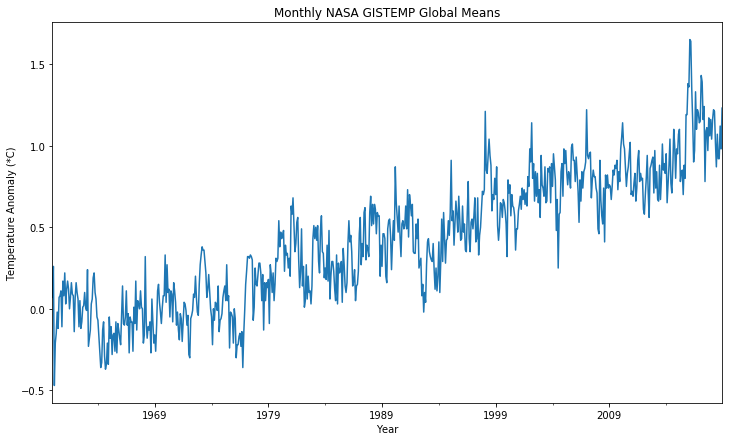

In [128]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
anomalyrange.anomaly.plot(ax=ax)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (*C)')
plt.title('Monthly NASA GISTEMP Global Means')
plt.show()


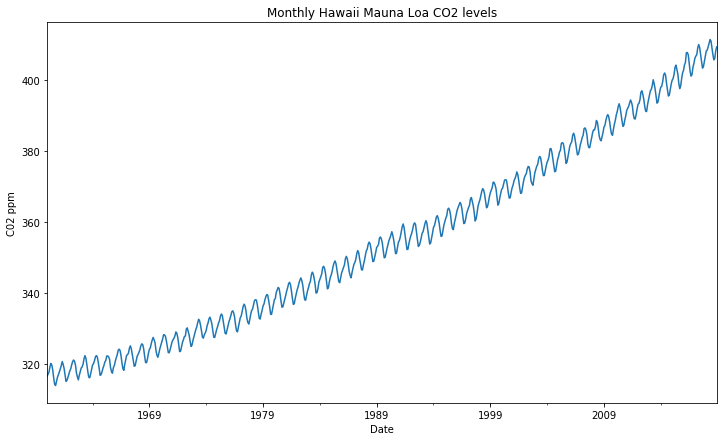

In [129]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
co2range.CO2filled.plot(ax=ax)

plt.xlabel('Date')
plt.ylabel('C02 ppm')
plt.title('Monthly Hawaii Mauna Loa CO2 levels')
plt.show()

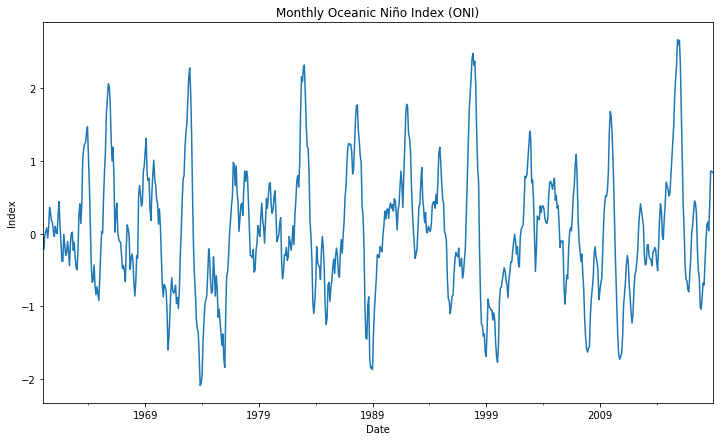

In [130]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
ensorange.ANOM.plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Index')
plt.title('Monthly Oceanic Niño Index (ONI)')
plt.show()

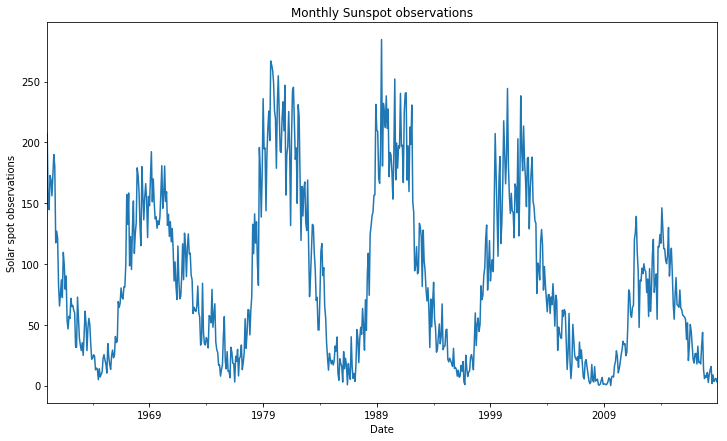

In [131]:
fig, ax = plt.subplots(1,1,figsize=(12,7))
spotsrange.SNvalue.plot(ax=ax)
plt.xlabel('Date')
plt.ylabel('Solar spot observations')
plt.title('Monthly Sunspot observations')
plt.show()

## Seasonal Decompositions

### Temperature anomaly

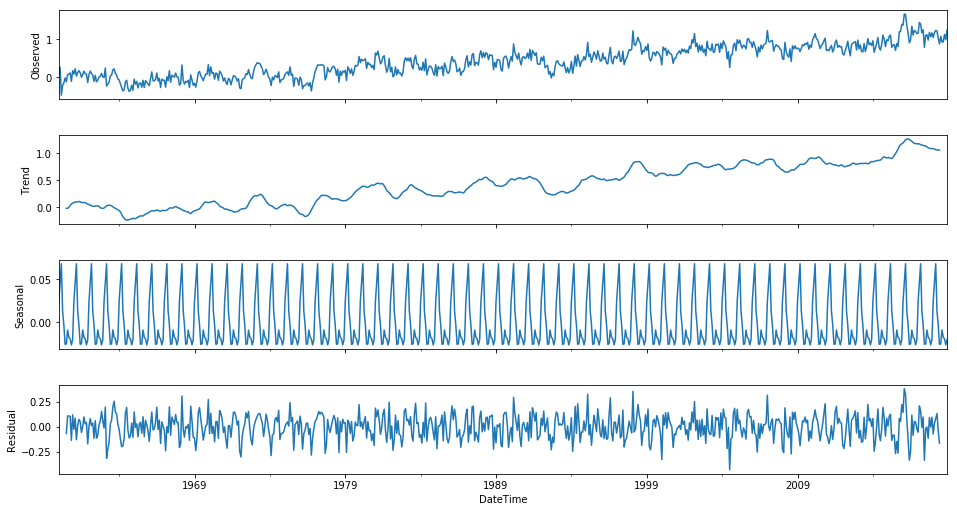

In [22]:
res = sm.tsa.seasonal_decompose(anomalyrange.anomaly,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### Hawaii CO2 ppm 

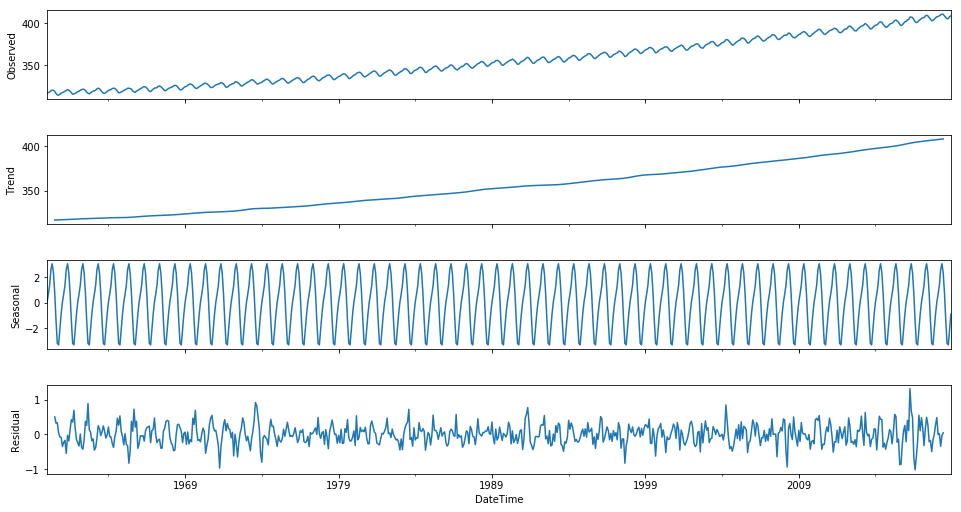

In [23]:
res = sm.tsa.seasonal_decompose(co2range.CO2filled,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### The Oceanic Niño Index (ONI)

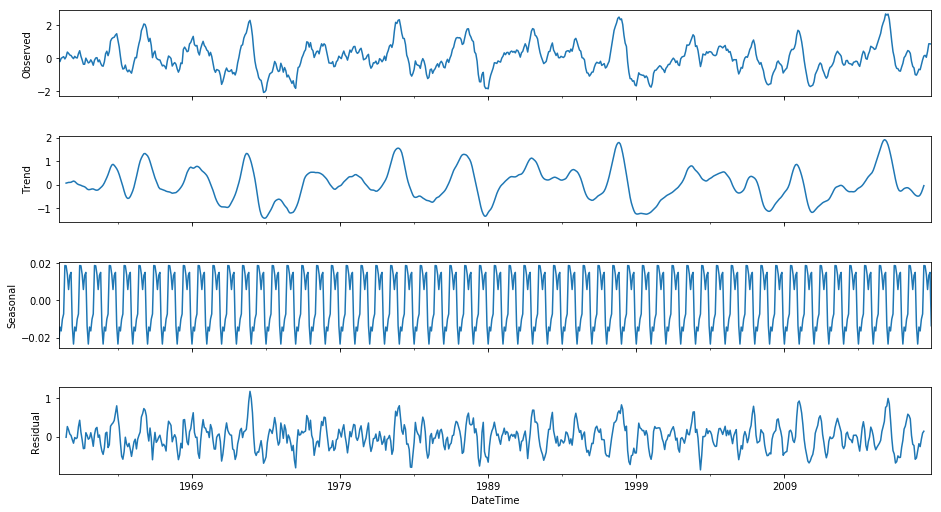

In [24]:
res = sm.tsa.seasonal_decompose(ensorange.ANOM,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

### Sunspot observations

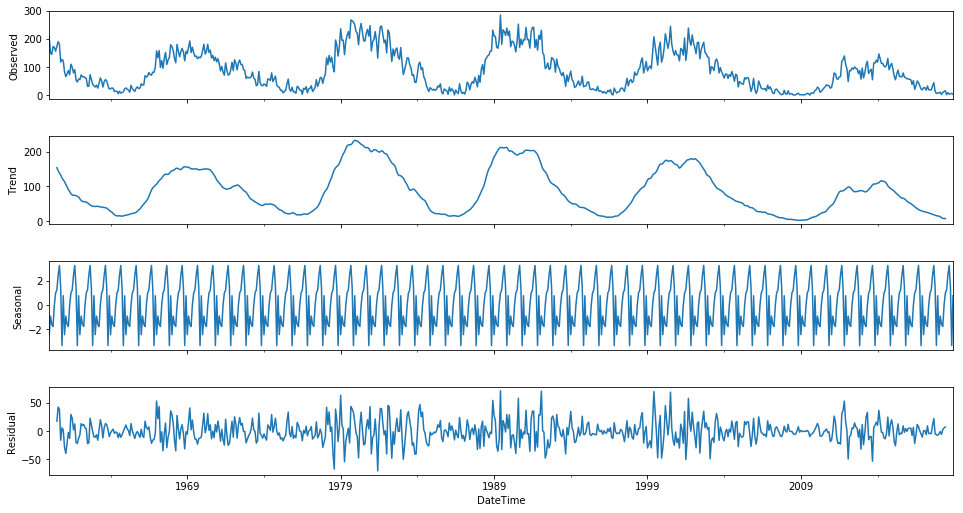

In [25]:
res = sm.tsa.seasonal_decompose(spotsrange.SNvalue,freq=12)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
plt.show()

## Model Selection

In [26]:
#ARIMA model:(p,d,q)
#SARIMA model:(p,d,q)(P,D,Q,m)
#ARIMAX model:(p,d,q) + exog
#SARIMAX model:(p,d,q)(P,D,Q,m) +exog

#ARIMA(p,d,q)
#p is the number of autoregressive terms,
#d is the number of nonseasonal differences needed for stationarity, and
#q is the number of lagged forecast errors in the prediction equation.

#P: Seasonal autoregressive order.
#D: Seasonal difference order.
#Q: Seasonal moving average order.
#m: The number of time steps for a single seasonal period.

### Checking Stationarity (Trend)

#### Temperature anomaly

Temperature anomaly lacks identifiable seasonal trend, but has a constant trend

In [27]:
res = sm.tsa.adfuller(anomalyrange.anomaly,regression='ct')
print('p-value:{}'.format(res[1]))
# data does not have a unit root and is stationary

p-value:1.6042922157092146e-09


In [28]:
res = sm.tsa.adfuller(anomalyrange.anomaly,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.5914744988244862


#### Hawaii CO2 ppm 

CO2 concentration has both a seasonal and a constant trend

In [29]:
res = sm.tsa.adfuller(co2range.CO2filled,regression='ct')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.9885944880242227


In [30]:
res = sm.tsa.adfuller(co2range.CO2filled,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:1.0


#### The Oceanic Niño Index (ONI) and Sunspot observations

ONI and Sunspot observations have no trend

In [31]:
res = sm.tsa.adfuller(ensorange.ANOM,regression='ct')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:4.519555052443993e-08


In [32]:
res = sm.tsa.adfuller(ensorange.ANOM,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:2.5062854384841634e-09


In [33]:
res = sm.tsa.adfuller(spotsrange.SNvalue,regression='ct')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.0030167208232305537


In [34]:
res = sm.tsa.adfuller(spotsrange.SNvalue,regression='c')
print('p-value:{}'.format(res[1]))
# data has a unit root and is non-stationary.

p-value:0.0007375824522553518


### Correlograms

#### Temperature anomaly

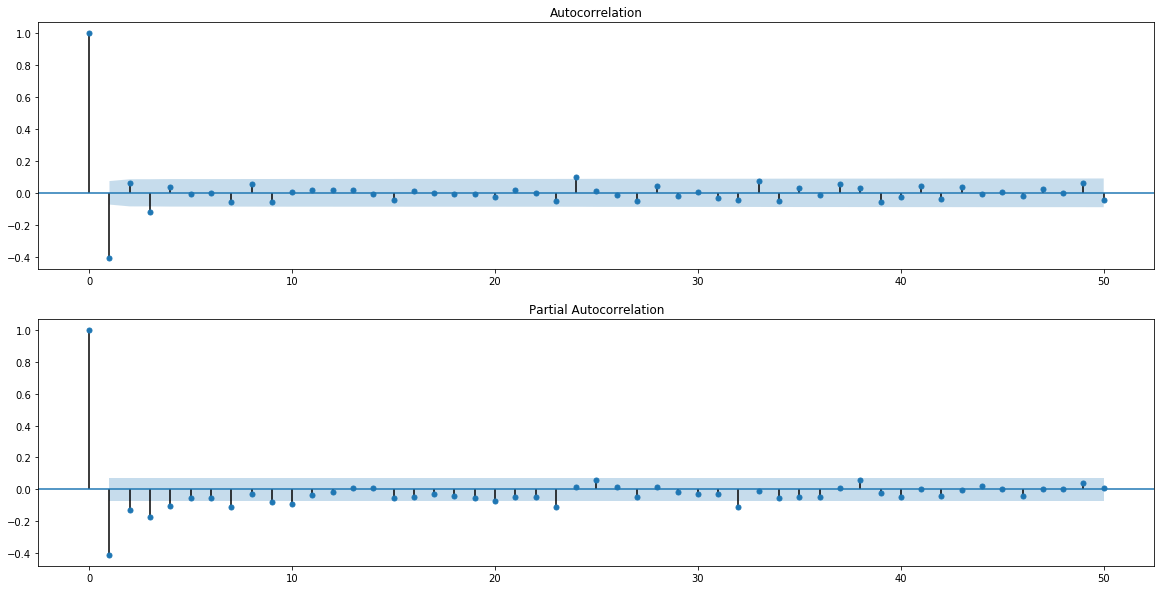

In [36]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(anomalyrange.anomaly.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(anomalyrange.anomaly.diff().dropna(), lags=50, ax=ax[1])
plt.show()

#### Hawaii CO2 ppm

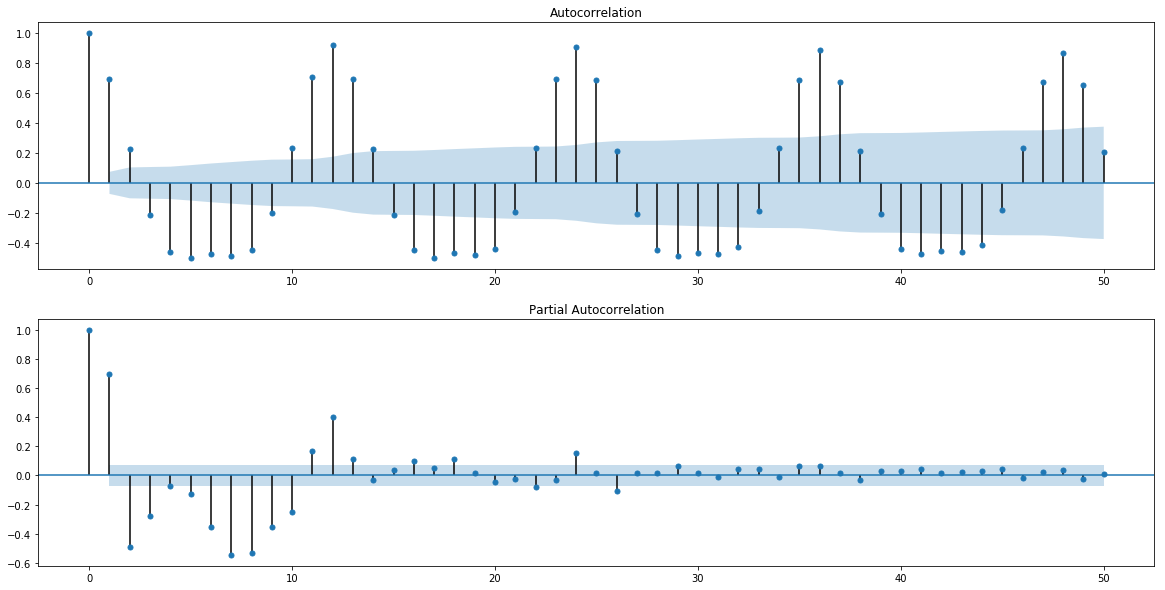

In [37]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(co2range.CO2filled.diff().dropna(), lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(co2range.CO2filled.diff().dropna(), lags=50, ax=ax[1])
plt.show()

#### The Oceanic Niño Index (ONI) 

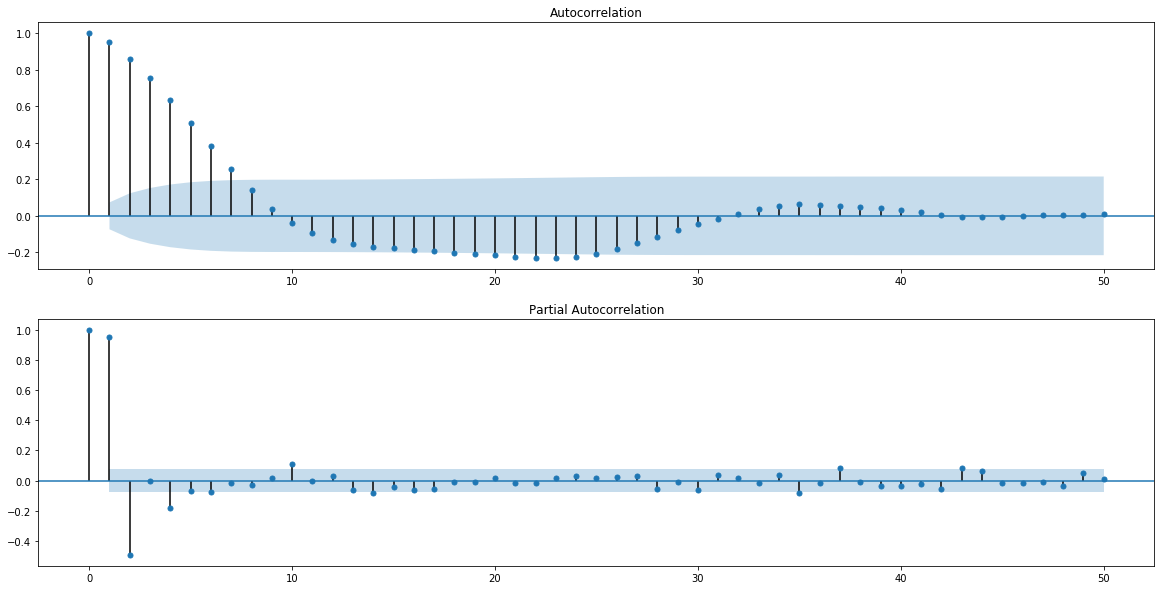

In [38]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(ensorange.ANOM, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(ensorange.ANOM, lags=50, ax=ax[1])
plt.show()

#### Sunspot observations

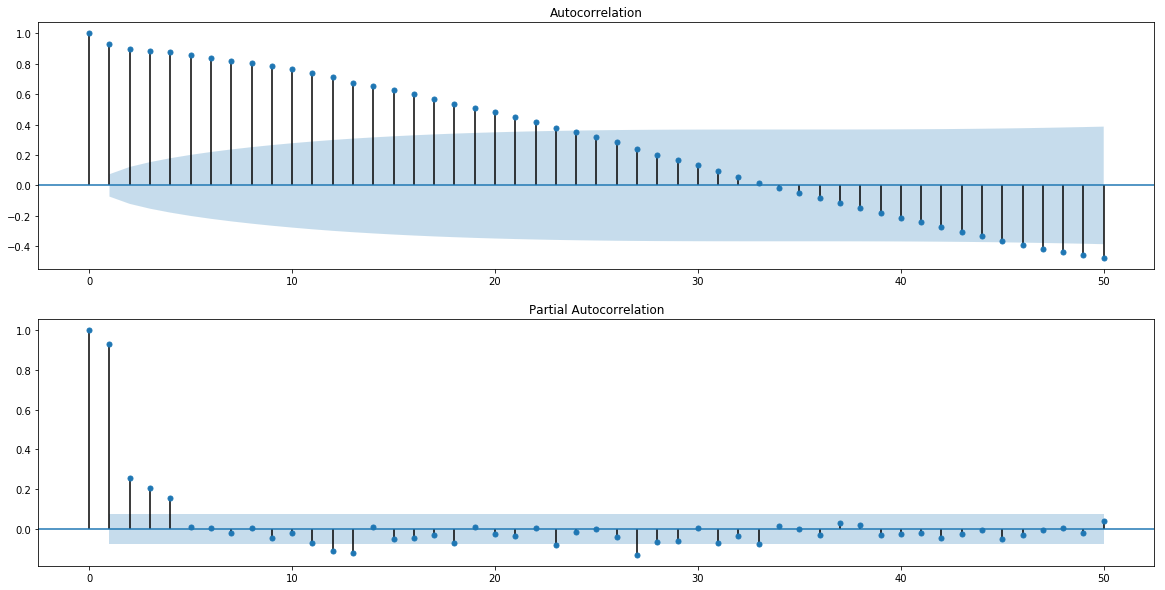

In [39]:
fig,ax = plt.subplots(2,1,figsize=(20,10))
fig = sm.graphics.tsa.plot_acf(spotsrange.SNvalue, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(spotsrange.SNvalue, lags=50, ax=ax[1])
plt.show()

### Train/Test-split

In [132]:
tr_start,tr_end = '1960-01-01','2012-12-01'
te_start,te_end = '2013-01-01','2018-12-01'

train_anomaly, test_anomaly = anomalyrange[tr_start : tr_end], anomalyrange[te_start:te_end]
train_co2, test_co2 = co2range[tr_start : tr_end], co2range[te_start: te_end]
train_enso, test_enso = ensorange[tr_start : tr_end], ensorange[te_start: te_end]
train_spots, test_spots = spotsrange[tr_start : tr_end], spotsrange[te_start: te_end]
train_exogenous, test_exogenous = exogenous[tr_start : tr_end], exogenous[te_start: te_end]


### Gridsearch Hyperparameter selection

Alternative for the incode parameter selection, does not  support exogenous information 

SARIMA-gridsearch code from:
https://machinelearningmastery.com/how-to-grid-search-sarima-model-hyperparameters-for-time-series-forecasting-in-python/


format gridsearch.py filename.csv. You need to edit the sys.argv[1] parameter in to run these commands


In [ ]:
%run -i gridsearch.py anomalyrange.csv

In [55]:
#Best parameters for anomaly:
#[(2, 0, 2), (2, 0, 0, 0), 'c'] 0.16027624541442012
#[(2, 1, 2), (0, 0, 0, 0), 'c'] 0.16167729212744297
#[(1, 1, 1), (0, 0, 2, 0), 'c'] 0.16190864182572434

In [ ]:
%run -i gridsearch.py co2range.csv

In [ ]:
%run -i gridsearch.py ensorange.csv

In [ ]:
%run -i gridsearch.py spotsrange.csv

## SARIMA model

In [143]:
sarima = sm.tsa.statespace.SARIMAX(train_anomaly,order=(2,1,2),trend='c',seasonal_order=(0,0,0,0),
                                 enforce_stationarity=False, enforce_invertibility=False,).fit()

sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  636
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 351.472
Date:                Sat, 16 Feb 2019   AIC                           -690.943
Time:                        21:35:03   BIC                           -664.212
Sample:                    01-01-1960   HQIC                          -680.565
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0007      0.000      5.343      0.000       0.000       0.001
ar.L1          0.2100      0.128      1.641      0.101      -0.041       0.461
ar.L2          0.4008      0.074      5.408      0.000       0.256       0.546
ma.L1         -0.7297      0.148     -4.932      0.000      -1.020      -0.440
ma.L2         -0.2695      0.134     -2.017      0.044      -0.531      -0.008
sigma2         0.0186      0.001     14.129      0.000       0.016       0.021
===================================================================================
Ljung-Box (Q):                       52.28   Jarque-Bera (JB):                 2.39
Prob(Q):                              0.09   Prob(JB):                         0.30
Heteroskedasticity (H):               1.09   Skew:                             0.12
Prob(H) (two-sided):                  0.52   Kurtosis:                         3.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA model MSE:0.048371172476643326


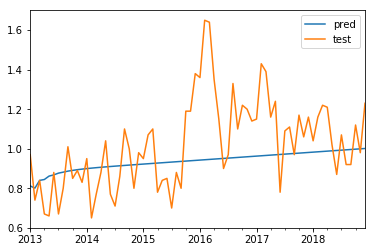

In [144]:
pred = sarima.predict(tr_end,te_end)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_anomaly,pred)))

pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred}).plot();plt.show()

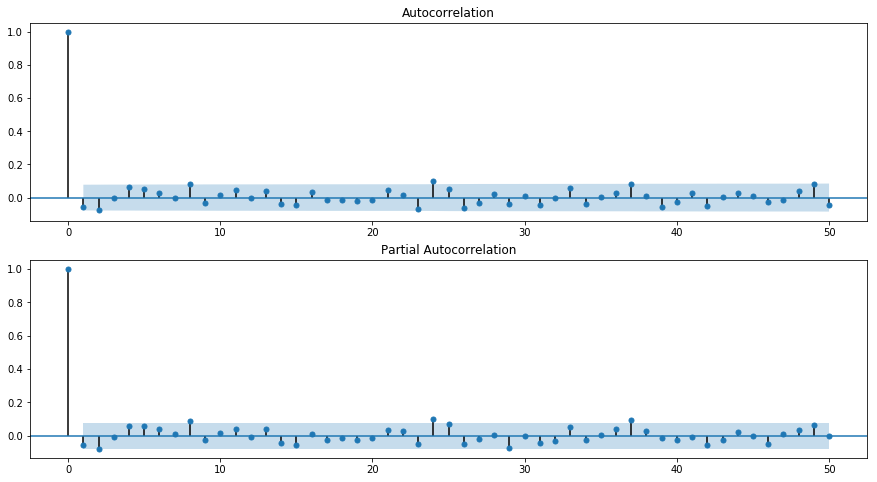

In [145]:
res = sarima.resid
fig,ax = plt.subplots(2,1,figsize=(15,8))
fig = sm.graphics.tsa.plot_acf(res, lags=50, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(res, lags=50, ax=ax[1])
plt.show()

### SARIMAX-model with CO2 as exogenous data

In [138]:
#p = d = q = range(0, 2)
p = range(0,3)
d = range(0,2)
q = range(0,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [139]:
warnings.filterwarnings("ignore") 

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_anomaly,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            exog=train_co2
                                            )

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:152.53349744156617
SARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:168.5271133882833
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-373.2577509057026
SARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:-362.6030031096469
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-110.3306275718104
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-373.0339911063252
SARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:-363.5348294307245
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-210.87787465466934
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-370.9172475511349
SARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:-360.74863718801157
SARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:-224.41342578645646
SARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:-369.1789257117073
SARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:-364.6251886869286
SARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:-261.09855458349404
SARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:-364.8585456760154
SARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:-363.77113710830514
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:5.171266745891941
SARIMA(0, 0, 1)x(0, 0, 1, 12

SARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:-644.6707185824716
SARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:-631.0821948427363
SARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:-669.3643850595802
SARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:-655.6628570752237
SARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:-654.9372391937934
SARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:-479.30897181642945
SARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:-642.8386316060834
SARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:-631.5418705802167
SARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:-658.2292148458033
SARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:-659.630521166544
SARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:-650.6387298177218
SARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:-525.408402063018
SARIMA(1, 0, 2)x(2, 1, 1, 12)12 - AIC:-629.5499272120462
SARIMA(1, 0, 2)x(2, 1, 2, 12)12 - AIC:-633.4511817751943
SARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-625.0209217263945
SARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-627.337264848923
SARIMA(1, 1, 0)x(0, 0, 2, 12)12 - AIC:-616.2546370502973
SARIMA(1, 1, 0)x(0, 1, 0, 12)12 -

SARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:-626.0867515217836
SARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:-618.7211718113349
SARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:-685.7715751719095
SARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:-683.8932869946302
SARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:-669.0606232947576
SARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:-471.75788754143815
SARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:-630.6199589882874
SARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:-617.1875500411579
SARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:-672.8586765395794
SARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:-672.0286420043623
SARIMA(2, 1, 1)x(2, 0, 2, 12)12 - AIC:-669.7674209466708
SARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:-514.399114272705
SARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:-617.3533742146337
SARIMA(2, 1, 1)x(2, 1, 2, 12)12 - AIC:-620.4244795209165
SARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:-690.5976064583851
SARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:-683.3932510471348
SARIMA(2, 1, 2)x(0, 0, 2, 12)12 - AIC:-669.1722981056325
SARIMA(2, 1, 2)x(0, 1, 0, 12)12

In [ ]:
#Best parameters:
#SARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-506.3849541853739
#SARIMA(0, 0, 2)x(0, 1, 1, 12)12 - AIC:-591.1336757476166
#SARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:-598.171093948506
#SARIMA(0, 0, 2)x(0, 1, 1, 12)12 - AIC:-591.1336757476166
#SARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-682.6628888297496
#SARIMA(0, 1, 2)x(0, 0, 0, 12)12 - AIC:-678.1557308869063
#SARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:-680.2208349877351
#ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-685.915798331581
#SARIMA(2, 0, 2)x(0, 0, 0, 12)12 - AIC:-680.3373996442947
#SARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:-683.3932510471348

In [140]:
sarimax = sm.tsa.statespace.SARIMAX(train_anomaly,order=(2,1,2),seasonal_order=(0,0,1,12),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train_co2).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                            anomaly   No. Observations:                  636
Model:             SARIMAX(2, 1, 2)x(0, 0, 1, 12)   Log Likelihood                 348.697
Date:                            Sat, 16 Feb 2019   AIC                           -683.393
Time:                                    21:34:41   BIC                           -652.207
Sample:                                01-01-1960   HQIC                          -671.285
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CO2filled      0.0099      0.003      3.914      0.000       0.005       0.015
ar.L1          0.7952      0.155      5.135      0.000       0.492       1.099
ar.L2          0.0244      0.098      0.250      0.803      -0.167       0.216
ma.L1         -1.3811      0.151     -9.136      0.000      -1.677      -1.085
ma.L2          0.3903      0.146      2.670      0.008       0.104       0.677
ma.S.L12      -0.0157      0.042     -0.377      0.706      -0.097       0.066
sigma2         0.0189      0.001     17.579      0.000       0.017       0.021
===================================================================================
Ljung-Box (Q):                       46.87   Jarque-Bera (JB):                 0.87
Prob(Q):                              0.21   Prob(JB):                         0.65
Heteroskedasticity (H):               1.25   Skew:                             0.08
Prob(H) (two-sided):                  0.11   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA model MSE:0.0467690957739377


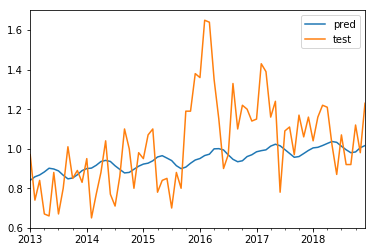

In [141]:
pred = sarimax.predict(tr_end,te_end,exog=test_co2)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_anomaly,pred)))

pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred}).plot();plt.show()

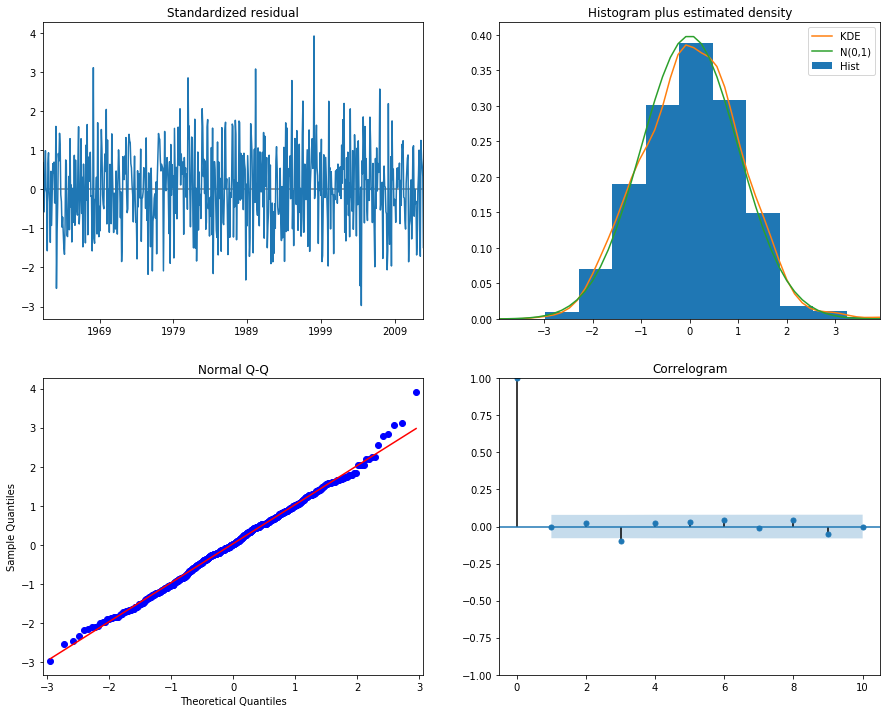

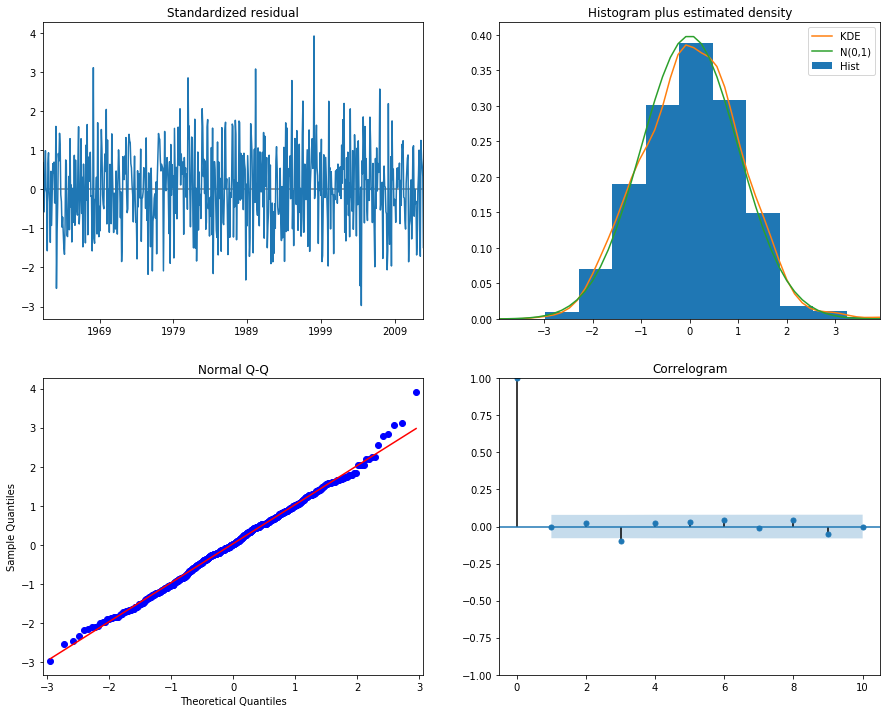

In [142]:
sarimax.plot_diagnostics(figsize=(15, 12))

### SARIMAX-model with all Exogenous data

In [105]:
#p = d = q = range(0, 2)
p = range(0,3)
d = range(0,2)
q = range(0,3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [107]:
warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train_anomaly,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False,
                                            exog=train_exogenous
                                            )

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))

        except:
            continue

SARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:268.3668550771079
SARIMA(0, 0, 0)x(0, 0, 2, 12)12 - AIC:189.25778003545557
SARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-419.2603293174624
SARIMA(0, 0, 0)x(0, 1, 2, 12)12 - AIC:-403.70150657918464
SARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-123.87929046830206
SARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-362.0400589150881
SARIMA(0, 0, 0)x(1, 0, 2, 12)12 - AIC:-310.70875556560543
SARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-246.59795534660736
SARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-386.7188802130672
SARIMA(0, 0, 0)x(1, 1, 2, 12)12 - AIC:-401.8391599539588
SARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:-254.29146086962396
SARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:-327.30543547451293
SARIMA(0, 0, 0)x(2, 0, 2, 12)12 - AIC:-384.4847005749366
SARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:-302.129493348883
SARIMA(0, 0, 0)x(2, 1, 1, 12)12 - AIC:-370.95627481282804
SARIMA(0, 0, 0)x(2, 1, 2, 12)12 - AIC:-399.1235818766644
SARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:22.918068350112804
SARIMA(0, 0, 1)x(0, 0, 1, 

SARIMA(1, 0, 2)x(0, 1, 1, 12)12 - AIC:-646.3041440473866
SARIMA(1, 0, 2)x(0, 1, 2, 12)12 - AIC:-632.2130920379844
SARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:-639.6288629455141
SARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:-653.6345936868736
SARIMA(1, 0, 2)x(1, 0, 2, 12)12 - AIC:-650.7556336159035
SARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:-477.04077027629296
SARIMA(1, 0, 2)x(1, 1, 1, 12)12 - AIC:-632.3623688031564
SARIMA(1, 0, 2)x(1, 1, 2, 12)12 - AIC:-632.4563512074253
SARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:-642.9123410177021
SARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:-655.8661931341701
SARIMA(1, 0, 2)x(2, 0, 2, 12)12 - AIC:-648.9805319622399
SARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:-519.9908114114016
SARIMA(1, 0, 2)x(2, 1, 1, 12)12 - AIC:-603.4274369577885
SARIMA(1, 0, 2)x(2, 1, 2, 12)12 - AIC:-632.9705514376766
SARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-622.0037554251356
SARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-624.3723455897697
SARIMA(1, 1, 0)x(0, 0, 2, 12)12 - AIC:-613.0329296691806
SARIMA(1, 1, 0)x(0, 1, 0, 12)1

SARIMA(2, 1, 1)x(0, 1, 1, 12)12 - AIC:-628.6868578952808
SARIMA(2, 1, 1)x(0, 1, 2, 12)12 - AIC:-621.2702298109649
SARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:-674.3897100356273
SARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:-672.4287249175377
SARIMA(2, 1, 1)x(1, 0, 2, 12)12 - AIC:-655.9929454363637
SARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:-471.8739164859113
SARIMA(2, 1, 1)x(1, 1, 1, 12)12 - AIC:-626.9855116970062
SARIMA(2, 1, 1)x(1, 1, 2, 12)12 - AIC:-618.5816755453721
SARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:-660.5395878566071
SARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:-657.8216513531255
SARIMA(2, 1, 1)x(2, 0, 2, 12)12 - AIC:-657.2060210472416
SARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:-514.5153589807915
SARIMA(2, 1, 1)x(2, 1, 1, 12)12 - AIC:-565.7780103277125
SARIMA(2, 1, 1)x(2, 1, 2, 12)12 - AIC:-620.6778400662386
SARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:-688.2766397735196
SARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:-680.2113252392235
SARIMA(2, 1, 2)x(0, 0, 2, 12)12 - AIC:-665.4579465762481
SARIMA(2, 1, 2)x(0, 1, 0, 12)12

In [ ]:
#Best parameters:
#SARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-681.4464470288331
#SARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-685.2315859480459
#SARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:-688.2766397735196

In [133]:
#https://www.windows2universe.org/sun/activity/sunspot_cycle.html&edu=mid has an eleven year cycle
sarimax = sm.tsa.statespace.SARIMAX(train_anomaly,order=(0,1,1),seasonal_order=(0,0,0,12),
                                 enforce_stationarity=False, enforce_invertibility=False,exog=train_exogenous).fit()
sarimax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                anomaly   No. Observations:                  636
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 345.723
Date:                Sat, 16 Feb 2019   AIC                           -681.446
Time:                        20:43:38   BIC                           -659.170
Sample:                    01-01-1960   HQIC                          -672.798
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CO2filled      0.0056      0.003      1.942      0.052   -5.27e-05       0.011
ANOM           0.0215      0.015      1.484      0.138      -0.007       0.050
SNvalue     7.257e-05      0.000      0.292      0.770      -0.000       0.001
ma.L1         -0.5903      0.033    -17.778      0.000      -0.655      -0.525
sigma2         0.0196      0.001     17.663      0.000       0.017       0.022
===================================================================================
Ljung-Box (Q):                       61.99   Jarque-Bera (JB):                 0.73
Prob(Q):                              0.01   Prob(JB):                         0.69
Heteroskedasticity (H):               1.19   Skew:                             0.06
Prob(H) (two-sided):                  0.22   Kurtosis:                         3.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

SARIMA model MSE:0.06640559723921073


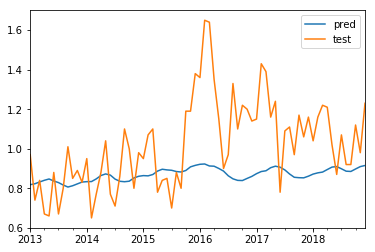

In [137]:
pred = sarimax.predict(tr_end,te_end,exog=test_exogenous)[1:]
print('SARIMA model MSE:{}'.format(mean_squared_error(test_anomaly,pred)))

pd.DataFrame({'test':test_anomaly.values.flatten(),'pred':pred}).plot();plt.show()

In [ ]:
sarimax.plot_diagnostics(figsize=(15, 12))

# Final predictions

## SARIMA model

Simple Sarima model with no exogenous variables predicts that temperature anomaly most likely stays constant